# This a sentiment analysis task that  design and optimization of the model, as well as potentially utilizing advanced NLP techniques such as fine-tuning pre-trained models like BERT. In a local Python environment where you can use TensorFlow and Keras, I took an optimized approach using a more complex LSTM model, incorporating some advanced techniques that help improve the accuracy.

## Import Libraries:

#### numpy and tensorflow are foundational libraries for numerical operations and machine learning.
#### Classes imported from tensorflow.keras are used to build neural network models:
- Sequential for linear stacking of layers.
- Embedding, LSTM, Dense, Dropout, and Bidirectional for different types of neural network layers.
- Tokenizer and pad_sequences are utilities for text processing.
- train_test_split from sklearn is used for splitting data into training and test sets.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split

In [25]:
print(tf.__version__)

2.10.0


## Load and Preprocess Data:

### Download the NLP dataset Amazon Sentiment Review form Kaggle
#### https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

- Reads each line, splits it to separate the label from the review, assigns binary labels (1 for positive, 0 for negative), and stores the results in lists.

- Converts the label list to a NumPy array for further processing.


In [ ]:
# Load the data (example path, replace with your actual path)
file_path= 'Dataset/train.txt'

# Preprocess the data
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

labels = []
reviews = []
for line in lines:
    split_line = line.strip().split(' ', 1)
    label = 1 if split_line[0] == '__label__2' else 0
    review = split_line[1]
    labels.append(label)
    reviews.append(review)

labels = np.array(labels)


## Tokenization and Sequence Padding:

- Initializes a Tokenizer object, specifying a maximum vocabulary size of 10,000 words and an out-of-vocabulary token <OOV>.
- Fits the tokenizer on the collected reviews, creating an index of all unique words.
- Converts the reviews into lists of integers based on the tokenizer's word index.
- Pads these sequences to a fixed length of 250, ensuring all input data has consistent dimensions, necessary for training neural networks.

In [ ]:
# Tokenizing and padding text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=250)

## Loading Pre-trained GloVe Embeddings

### Download the Glove Embedding from Kaggle

####  https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

- Defines a function to load the GloVe (Global Vectors for Word Representation) embeddings.
- Reads the GloVe file, parsing each line to extract the word and its corresponding coefficient vector.
- Creates an embedding matrix that maps each word in the tokenizer's index to its GloVe vector, if available. Words not in GloVe will have a vector of zeros.


In [ ]:
# # Load pre-trained GloVe embeddings

def load_glove_embeddings(path, word_index, embedding_dim):
    embeddings_index = {}
    # Open the file with UTF-8 encoding specified
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    # Prepare embedding matrix
    num_words = min(len(word_index) + 1, 10000)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:  # Corrected line here
            # Use the embedding vector for words found in the GloVe index
            embedding_matrix[i] = embedding_vector  # words not found will be all-zeros.

    return embedding_matrix



In [ ]:
embedding_dim = 100  # Size of the GloVe vectors you're using
glove_path = 'Embedding/glove.6B.100d/glove.6B.100d.txt'
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)


## Model Definition and Compilation:

- Defines a sequential model for sentiment analysis.
- Adds an Embedding layer to transform indices into dense vectors of fixed size.
- Utilizes Bidirectional layers with LSTM units to capture patterns from both forward and backward states of the input sequence.
- Adds Dense layers with ReLU activation for non-linear transformations and a dropout layer to reduce overfitting.
- The final output layer uses a sigmoid activation function for binary classification.
- Compiles the model with the Adam optimizer and binary cross-entropy loss function, tracking accuracy as a metric.

In [ ]:
# Build the model
model = Sequential([
    Embedding(10000, embedding_dim, embeddings_initializer=Constant(embedding_matrix),
              input_length=250, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 256)         234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 250, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


## Model Training:

- Trains the model on the padded text sequences and labels.
- Runs for 5 epochs with 20% of the data reserved for validation to monitor performance and mitigate overfitting.

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)


Epoch 1/5
1093/1093 [==============================] - 1457s 1s/step - loss: 0.3991 - accuracy: 0.8189 - val_loss: 0.3092 - val_accuracy: 0.8722
Epoch 2/5
1093/1093 [==============================] - 1371s 1s/step - loss: 0.2911 - accuracy: 0.8783 - val_loss: 0.2605 - val_accuracy: 0.8944
Epoch 3/5
1093/1093 [==============================] - 1641s 2s/step - loss: 0.2511 - accuracy: 0.8970 - val_loss: 0.2432 - val_accuracy: 0.9026
Epoch 4/5
1093/1093 [==============================] - 1400s 1s/step - loss: 0.2308 - accuracy: 0.9075 - val_loss: 0.2350 - val_accuracy: 0.9058
Epoch 5/5
1093/1093 [==============================] - 1400s 1s/step - loss: 0.2066 - accuracy: 0.9193 - val_loss: 0.2306 - val_accuracy: 0.9133


## Save the Train Model

In [ ]:
# Save the model
model.save('sentiment_model.h5')

In [ ]:
# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Evaluate

- Evaluate the model Validation loss
- Evaluate the model Validation accuracy


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

547/547 [==============================] - 191s 349ms/step - loss: 0.2306 - accuracy: 0.9133
Validation loss: 0.23057065904140472
Validation accuracy: 0.9132547974586487


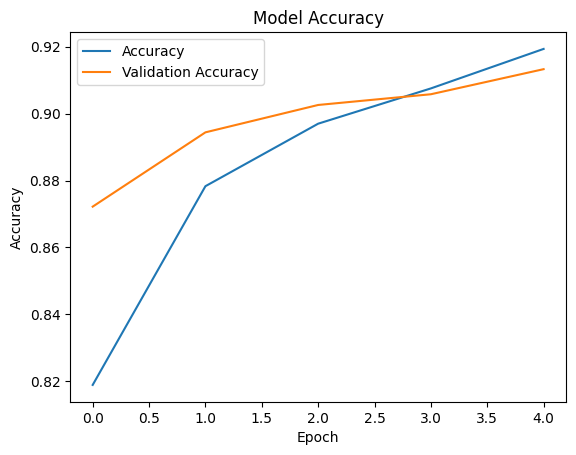

In [ ]:
#  plot the training history to visualize the learning over epochs:
import matplotlib.pyplot as plt
# Plotting training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Model Load

- load the sentiment_model.h5 model from you dir

In [19]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('sentiment_model.h5')

In [20]:
# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [21]:
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Utility Functions for Text Preprocessing and Sentiment Prediction:

- preprocess_text converts input texts into padded sequences suitable for model input, using the previously defined tokenizer.
- predict_sentiment processes texts, makes predictions with the trained model, and interprets the results as 'Positive' or 'Negative' based on the prediction score.

In [ ]:
def preprocess_text(texts, tokenizer, max_length=250):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

def predict_sentiment(texts, model, tokenizer):
    preprocessed_texts = preprocess_text(texts, tokenizer)
    predictions = model.predict(preprocessed_texts)
    print("predictions",predictions)
    sentiment_labels = ['Negative' if pred < 0.5 else 'Positive' for pred in predictions.flatten()]
    return sentiment_labels

## Sentiment Prediction on New Reviews:

- Lists new review texts to test the model.
- Calls predict_sentiment to determine the sentiment of each review.
- Prints out each review with its predicted sentiment, providing a practical demonstration of the model in action.

In [ ]:
# Example reviews
new_reviews = [
    "I absolutely loved this product, it worked wonders for me!",
    "Horrible experience, it broke down the first time I used it.",
    "Okay product, but I expected something better.",
    "Perfect, just as described! Would buy again!",
    "Not worth the money, very disappointing.",
    "If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated.",
     "Review of Kelly Club for Toddlers: For the price of 7.99, this PC game is WELL worth it, great graphics, colorful and lots to do! My four year old daughter is in love with the many tasks to complete in this game, including dressing and grooming wide variety of pets and decoration of numerous floats to show in your little one's very own parade."
]

# Predict sentiments
sentiments = predict_sentiment(new_reviews, model, tokenizer)
# print(sentiments)
for review, sentiment in zip(new_reviews, sentiments):
    print(f"Review: {review}\nSentiment: {sentiment}\n")

1/1 [==============================] - 0s 245ms/step
predictions [[0.9961173 ]
 [0.00163375]
 [0.5040343 ]
 [0.9762217 ]
 [0.00119857]
 [0.15386383]
 [0.98825365]]
Review: I absolutely loved this product, it worked wonders for me!
Sentiment: Positive

Review: Horrible experience, it broke down the first time I used it.
Sentiment: Negative

Review: Okay product, but I expected something better.
Sentiment: Positive

Review: Perfect, just as described! Would buy again!
Sentiment: Positive

Review: Not worth the money, very disappointing.
Sentiment: Negative

Review: If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated.
Sentiment: Negative

Review: Review of Kelly Club for Toddlers: For the price of 7.99, this PC game is WELL worth it, great graphics, colorful and lots to do! My four year old daughter is in love with the many tasks to complete in this game, including dressing and grooming wide variety 

In [22]:
def preprocess_text(text, tokenizer, max_length=250):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

def predict_sentiment(text, model, tokenizer):
    preprocessed_text = preprocess_text(text, tokenizer)
    prediction = model.predict(preprocessed_text)[0]
    print("Prediction:", prediction)
    sentiment_label = 'Negative' if prediction < 0.5 else 'Positive'
    return sentiment_label

# Example review
new_review = "very bad product"

# Predict sentiment
sentiment = predict_sentiment(new_review, model, tokenizer)
print(f"Review: {new_review}\nSentiment: {sentiment}\n")

1/1 [==============================] - 4s 4s/step
Prediction: [0.00288917]
Review: very bad product
Sentiment: Negative

